In [1]:
from __future__ import print_function
from gensim.models import KeyedVectors

# Creating the model
model = KeyedVectors.load_word2vec_format('./nlp/statics/model.vec')


In [2]:
#!wc -l ./statics/title_vect.vec
#!less ./statics/title_vect.vec


In [3]:
from __future__ import print_function
from gensim.models import KeyedVectors

title_vect = KeyedVectors.load_word2vec_format('./nlp/statics/title_vect_west.vec_new', binary=False)  # C text format
# Creating the model


In [4]:
import pandas as pd
file_name = './data/artworkstxt_info_west.csv'
artworks = pd.read_csv(file_name, error_bad_lines=False)

#artworks[:1000].fillna('无').info()
artworks['title'] = artworks['title'].fillna('无')
artworks['description'] = artworks['description'].fillna('无')



b'Skipping line 8151: expected 5 fields, saw 17\nSkipping line 9386: expected 5 fields, saw 6\nSkipping line 23476: expected 5 fields, saw 6\nSkipping line 23597: expected 5 fields, saw 6\nSkipping line 25255: expected 5 fields, saw 6\nSkipping line 49919: expected 5 fields, saw 13\nSkipping line 49920: expected 5 fields, saw 7\nSkipping line 68783: expected 5 fields, saw 10\nSkipping line 99120: expected 5 fields, saw 6\nSkipping line 104998: expected 5 fields, saw 14\nSkipping line 104999: expected 5 fields, saw 15\nSkipping line 105000: expected 5 fields, saw 10\n'


In [5]:
import jieba
def cut_sentence(input_sentence):
    try:
        word_list = list(jieba.cut(input_sentence))
    except AttributeError:
        word_list = [input_sentence]

    print(word_list)

    vic_list = []
    for k in word_list:
        try:
            vic_list.append(model.wv[k])
        except KeyError:
            pass
    return vic_list, word_list

In [6]:
def input2vect(input_sentence):
    vic_list,word_list = cut_sentence(input_sentence)

    if len(vic_list) > 0:
        input_vic = sum(vic_list) / len(vic_list)
        # print(model.similar_by_vector(title_vic, topn=1))
    else:
        input_vic = vic_list

    return  input_vic

In [7]:
import requests

picture_addr = './data/artwork.jpg'
def pull_picture(url, picture_addr):
    img_data = requests.get(url).content
    with open(picture_addr,'wb') as handler:
        handler.write(img_data)

In [8]:
import colorgram

def color_extract(picture_addr,number_of_colors):

    color_ex = colorgram.extract(picture_addr, number_of_colors)

    colors = []
    color_proportion =[]
    for color in color_ex:
        colors.append((color.rgb.r,color.rgb.g,color.rgb.b))
        color_proportion.append(color.proportion)

    return colors, color_proportion

In [96]:
import cv2 as cv 
import numpy as np
import random

def fill_color_demo(lineart_addr, colors):
    """
    漫水填充：会改变图像
    """
    image = cv.imread(lineart_addr)
    #print(type(image))


    # 复制图片
    copyImg = image.copy()
    # 获取图片的高和宽
    h, w = image.shape[:2]
    print(h,w)


    # 创建一个h+2,w+2的遮罩层，
    # 这里需要注意，OpenCV的默认规定，
    # 遮罩层的shape必须是h+2，w+2并且必须是单通道8位，具体原因我也不是很清楚。
    mask = np.zeros([h + 2, w + 2], np.uint8)

    # 这里执行漫水填充，参数代表：
    # copyImg：要填充的图片
    # mask：遮罩层
    # (30,30)：开始填充的位置（开始的种子点）
    # (0,255,255)：填充的值，这里填充成黄色
    # (100,100,100)：开始的种子点与整个图像的像素值的最大的负差值
    # (50,50,50)：开始的种子点与整个图像的像素值的最大的正差值
    # cv.FLOODFILL_FIXED_RANGE：处理图像的方法，一般处理彩色图象用这个方法
    i = 0
    counter =0
    while counter < 500000:
        r_x, r_y = (random.randint(0, h-1), random.randint(0, w-1))
        #print (r_x, r_y)
        seed_color = image[r_x, r_y]
        #print(seed_color.tolist())
        
        #print(colors[i])
        #print (seed_color)
        if seed_color.tolist() == [255, 255, 255]:
            try:
                #print('fill')
                cv.floodFill(copyImg, mask, (r_x, r_y), colors[i], (20, 20, 20), (50, 50, 50), cv.FLOODFILL_FIXED_RANGE)
                if i == number_of_colors: i = 0
                i += 1
            except Exception as e: a=1#print(e)
        #else: i += 1
        counter += 1
    #cv.imshow("fill color", copyImg)
    #cv.waitKey(0)
    #cv.destroyAllWindows()

    cv.imwrite('./data/预览.jpg', copyImg)


In [10]:
def add_alpha_channel(img):
    
    b_channel, g_channel, r_channel = cv.split(img)
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 50 #creating a dummy alpha channel image.
    img_BGRA = cv.merge((b_channel, g_channel, r_channel, alpha_channel))
    return img_BGRA

In [114]:
from blend_modes import blend_modes

def blend_multiply(file_foreground,file_background):
    # Import background image
    background_img_float = cv.imread(file_background,-1).astype(float)
    background_img_float = add_alpha_channel(background_img_float)

    # Import foreground image
    foreground_img_float = cv.imread(file_foreground,-1).astype(float)
    foreground_img_float = add_alpha_channel(foreground_img_float)

    # Blend images
    opacity = 1  # The opacity of the foreground that is blended onto the background is 70 %.
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    cv.imwrite('./data/预览2.jpg', blended_img_float)



['明快']
2006年作 清新 布面油画 http://img2.artron.net/auction/2009/art9164/d/art91640570.jpg


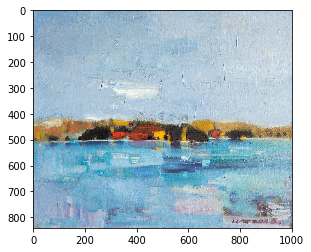

In [106]:
input_sentence = '明快'

vic = input2vect(input_sentence)
(ID, simlarity) = title_vect.similar_by_vector(vic, topn=10)[random.randint(0, 9)]

info = artworks.loc[int(ID)]
url = info.image_url
print(info.title,url)

pull_picture(url, picture_addr)



%matplotlib inline
from PIL import Image 
import matplotlib.pyplot as plt

image = Image.open(picture_addr)
plt.imshow(image)


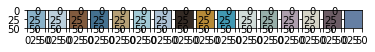

In [107]:
import colorgram
from matplotlib.gridspec import GridSpec

# #color_num = 16
# number_of_colors = 16

# # Extract 6 colors from an image.
# colors = colorgram.extract(picture_addr, number_of_colors)

number_of_colors = 16
colors,color_proportion = color_extract(picture_addr,number_of_colors)

number_of_colors = len(colors)



the_grid = GridSpec(1, number_of_colors)

for i in range(number_of_colors):

    plt.subplot(the_grid[0, i], aspect=1)

    im= Image.new("RGB", (50, 50),colors[i])
    #print((colors[i].rgb.r,colors[i].rgb.g,colors[i].rgb.b))
    plt.imshow(im)

        


In [128]:
topaint_dic = {'Interior design':('./data/330805-15032404153760_2.jpg','./data/330805-15032404153760.jpg'),
               'fashion design':('./data/58_2.jpg','./data/58.jpg')}
to_paint, line_art = topaint_dic['Interior design']


#to_paint = './data/58_2.jpg'
file_foreground = './data/预览.jpg'
file_background = line_art
#file_background = './data/58.jpg'

image = cv.imread(to_paint)
fill_color_demo(to_paint, colors)


833 1000


image2 = Image.open('./data/预览.jpg')
plt.imshow(image2)


In [130]:
blend_multiply(file_foreground,file_background)
#blend_multiply(file_background,file_foreground)

imagen = Image.open('./data/预览2.jpg')
plt.imshow(image2)
